# About Dataset

### Dataset

- The dataset used is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset)
- It consists of 1171 aerial images of the state of Massachusetts.
- Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

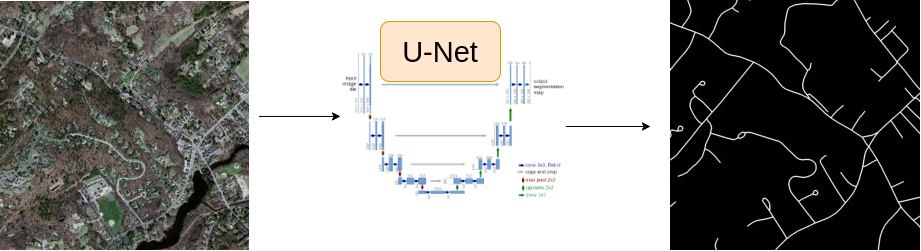

#Import Libraries

In [ ]:
!pip install segmentation-models-pytorch #for UNet model
!pip install -U git+https://github.com/albumentations-team/albumentations #library for image augmentation
!pip install --upgrade opencv-contrib-python #for OpenCV

In [ ]:
import torch
import cv2
import albumentations as A
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp #to use UNet architecture
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm #for representing progress bars for loops

import helper #import from helper.py for plotting images

import sys
sys.path.append('/content/Road_seg_dataset')

#Device Configuration

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#Hyperparameters

In [ ]:
#Hyperparameters:
epochs = 15
lr = 0.003
batch_size = 8
img_size = 512

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

# Download Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


In [ ]:
Data_DIR_Path = "/content/Road_seg_dataset/"
CSV_File_Path = f"{Data_DIR_Path}train.csv"

In [ ]:
#read CSV:
df = pd.read_csv(CSV_File_Path)

df.head() #show first 5 rows

In [ ]:
idx = 2 #index number of image

row = df.iloc[idx] #selects the idx row

img_path = Data_DIR_Path + row.images
mask_path = Data_DIR_Path + row.masks

img = cv2.imread(img_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converts from BGR format to RGB

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255 #reads images in grayscale
#it's going to be from 0-255 pixel values
#divides all pixel values by 255, normalizing it b/w 0 to 1

In [ ]:
#plotting img

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax2.set_title('GROUND TRUTH')

ax1.imshow(img)
ax2.imshow(mask,cmap = 'gray')

#Split Dataset

In [ ]:
#split dataset into train & validation set:

train_df, valid_df = train_test_split(df, test_size=0.20, random_state=123) #80% training set, 20% validation set

print(len(train_df))
print(len(valid_df))

159
40


#Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(img_size, img_size),  #resizes image to img_size * img_size
      A.HorizontalFlip(p = 0.5), #50% probability of fliping an image horizontally
      A.VerticalFlip(p = 0.5), #50% probability of fliping an image vertically
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(img_size, img_size)
  ])

#Create Custom Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_path = Data_DIR_Path + row.images
    mask_path = Data_DIR_Path + row.masks
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #mask is in format of (height, width)
    mask = np.expand_dims(mask, axis=-1) #adds a new dimension at last (h,w, channel)
    #channel will be 1, because image is grayscale

    if self.augmentations:
      data = self.augmentations(image = img, mask = mask) #applying augmentations, returns a dictionary format
      #extract image and mask from dictionary:
      img = data['image'] #shape: (h,w,c)
      mask = data['mask']

    #convert from (h,w,c) to (c,h,w) for giving to the network
    img = np.transpose(img, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    #convert to tensors:
    img = torch.Tensor(img) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return img, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Training Set Size: {len(trainset)}')
print(f'Validation Set Size: {len(validset)}')

Training Set Size: 159
Validation Set Size: 40


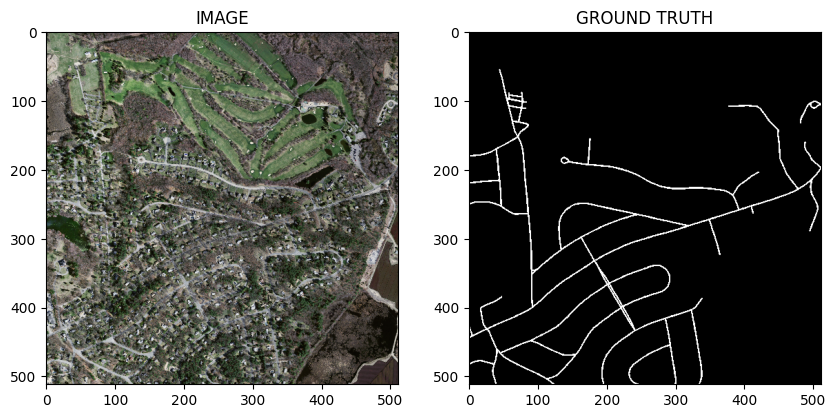

In [ ]:
#plotting a random image:
idx = 12

img, mask = trainset[idx]

#using function from helper.py
helper.show_image(img, mask)

#Load dataset into batches

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size = batch_size, shuffle=False)

In [ ]:
print(f'Total No. of Batches in TrainLoader: {len(trainloader)}') #159 / 8 = 19.875 = 20
print(f'Total No. of Batches in ValidLoader: {len(validloader)}') # 40/ 8 = 5

Total No. of Batches in TrainLoader: 20
Total No. of Batches in ValidLoader: 5


In [ ]:
for images, masks in trainloader:
  print(f'One Batch Image Shape: {images.shape}') #8 images, 3 channels, 512*512 img size
  print(f'One Batch Mask Shape: {masks.shape}') #8 images, 1 channels, 512*512 img size
  break

One Batch Image Shape: torch.Size([8, 3, 512, 512])
One Batch Mask Shape: torch.Size([8, 1, 512, 512])


#Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weights,
        in_channels = 3, #3 input channels for RGB
        classes = 1, #output pixel either as 0 or 1, binary segmentation model
        activation = None #the final activation will output logits i.e. without any sigmoid or softmax activation
    )

    #Unet_ is a fully convolution neural network for image semantic segmentation.

  def forward(self, images, masks=None):  #mask is none by default
    logits = self.backbone(images)
    if masks is not None:
        loss1 = DiceLoss(mode='binary')(logits, masks) #Dice loss for image segmentation task. It supports binary, multiclass and multilabel cases
        loss2 = nn.BCEWithLogitsLoss()(logits, masks) #Binary Cross Entropy
        return logits, loss1 + loss2
    else:
        return logits #if mask = None, during testing

In [ ]:
model = SegmentationModel().to(device)

#Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):

  model.train()  #set model to training mode

  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)

In [ ]:
def eval_fn(dataloader, model):

  model.eval()  #set model to evaluation mode

  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader): #tqdm for displaying a progress bar
      images = images.to(device)
      masks = masks.to(device)
      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss/len(dataloader)

#Training & Testing

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
best_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "Aerial_Img_Segmentation_Parameters.pt")
    print("Model saved!")
    best_loss = valid_loss

  print(f"Epoch: {i+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Best Model Loss: {best_loss:.4f}")

100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Model saved!
Epoch: 1/15, Training Loss: 1.2099, Validation Loss: 1.0400, Best Model Loss: 1.0400


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Model saved!
Epoch: 2/15, Training Loss: 0.8183, Validation Loss: 0.8058, Best Model Loss: 0.8058


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Model saved!
Epoch: 3/15, Training Loss: 0.7297, Validation Loss: 0.7486, Best Model Loss: 0.7486


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Model saved!
Epoch: 4/15, Training Loss: 0.7091, Validation Loss: 0.6838, Best Model Loss: 0.6838


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Model saved!
Epoch: 5/15, Training Loss: 0.6770, Validation Loss: 0.6530, Best Model Loss: 0.6530


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Model saved!
Epoch: 6/15, Training Loss: 0.6675, Validation Loss: 0.6429, Best Model Loss: 0.6429


100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch: 7/15, Training Loss: 0.6675, Validation Loss: 0.8897, Best Model Loss: 0.6429


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch: 8/15, Training Loss: 0.6366, Validation Loss: 0.6456, Best Model Loss: 0.6429


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Model saved!
Epoch: 9/15, Training Loss: 0.6513, Validation Loss: 0.6213, Best Model Loss: 0.6213


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch: 10/15, Training Loss: 0.6388, Validation Loss: 0.6261, Best Model Loss: 0.6213


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Model saved!
Epoch: 11/15, Training Loss: 0.6255, Validation Loss: 0.5810, Best Model Loss: 0.5810


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Epoch: 12/15, Training Loss: 0.6272, Validation Loss: 0.6471, Best Model Loss: 0.5810


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


Epoch: 13/15, Training Loss: 0.6102, Validation Loss: 0.6244, Best Model Loss: 0.5810


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch: 14/15, Training Loss: 0.5993, Validation Loss: 0.6251, Best Model Loss: 0.5810


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

Epoch: 15/15, Training Loss: 0.6090, Validation Loss: 0.5902, Best Model Loss: 0.5810


#Load Model

In [ ]:
idx = 5

newmodel = SegmentationModel().to(device)

newmodel.load_state_dict(torch.load("Aerial_Img_Segmentation_Parameters.pt"))

image, mask = validset[idx]

logits_mask = newmodel(image.to(device).unsqueeze(0)) #Converting image dimension from (channel, h, w) to (batch, channel, h, w)
#unsqueez(0) adds extra dimension for batch

pred_mask = torch.sigmoid(logits_mask) #applying sigmoid activation

pred_mask = (pred_mask > 0.5) * 1.0 #threshold: if pred mask > 0.5 then pred_mask = 1

<ipython-input-44-095388efa5e7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  newmodel.load_state_dict(torch.load("Aerial_Img_Segmentation_Model.pt"))


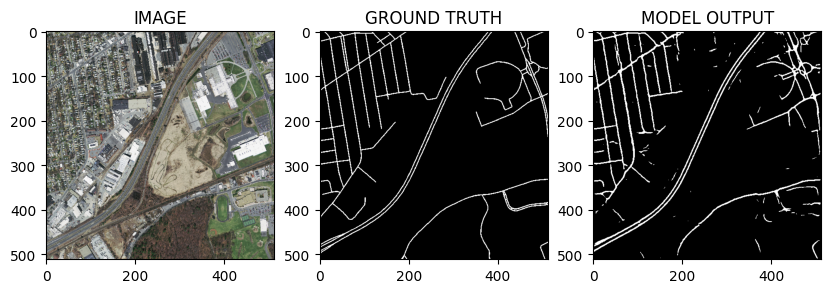

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))
#detaches tensor from computational graph and moves to cpu then removes the batch dimension from pred_mask